In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, PredefinedSplit, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [21]:
# train/test set creation

df = pd.read_json("../data/postdatalinesvectors.json",orient='records',lines=True)
X = df[[str(i) for i in range(300)]]
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=101)
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [22]:
# male/female train/test set creation

df = pd.read_json("../data/postdatalinesvectors.json",orient='records',lines=True)

df_male = df[df['gender'] == 'm']
df_female = df[df['gender'] == 'f']

# create male split
Xm = df_male[[str(i) for i in range(300)]]
ym = df_male['label']
X_trainm, X_testm, y_trainm, y_testm = train_test_split(Xm,ym, test_size=0.2, random_state=101)
# create female split
Xf = df_female[[str(i) for i in range(300)]]
yf = df_female['label']
X_trainf, X_testf, y_trainf, y_testf = train_test_split(Xf,yf, test_size=0.2, random_state=101)
# combine splits
X_train = pd.concat([X_trainm,X_trainf])
y_train = pd.concat([y_trainm,y_trainf])

X_test = pd.concat([X_testm,X_testf])
y_test = pd.concat([y_testm,y_testf])

# Scaling for SVM
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_trainm = scaler.fit_transform(X_trainm)
X_trainf = scaler.fit_transform(X_trainf)

X_test = scaler.transform(X_test)
X_testm = scaler.transform(X_testm)
X_testf = scaler.transform(X_testf)

In [23]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model = SVC(random_state=0, probability=True, class_weight='balanced', C=1, gamma=0.001, kernel='rbf')
model.fit(X_train,y_train)


def prediction_measures(y_test,X_test):
    model_pred = model.predict(X_test)
    print(classification_report(y_test, model_pred))
    confusionmatrix = confusion_matrix(y_test,model_pred)
    # display confusion matrix
    cm_display = ConfusionMatrixDisplay(confusion_matrix = confusionmatrix, display_labels = [False, True]) 
    cm_display.plot()
    plt.show()  


### Full set

              precision    recall  f1-score   support

  depression       0.92      0.95      0.94        88
      normal       0.94      0.90      0.92        72

    accuracy                           0.93       160
   macro avg       0.93      0.93      0.93       160
weighted avg       0.93      0.93      0.93       160



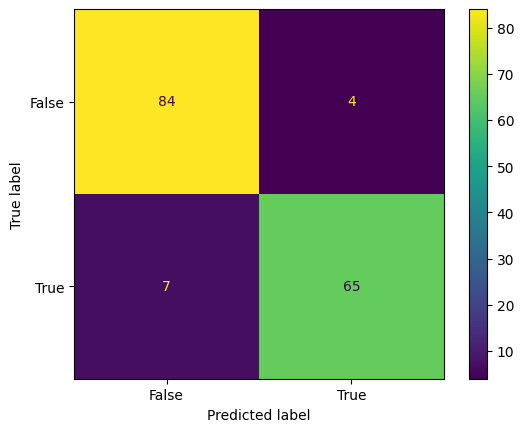

In [24]:
prediction_measures(y_test,X_test)

### Male set

              precision    recall  f1-score   support

  depression       0.91      0.91      0.91        22
      normal       0.94      0.94      0.94        31

    accuracy                           0.92        53
   macro avg       0.92      0.92      0.92        53
weighted avg       0.92      0.92      0.92        53



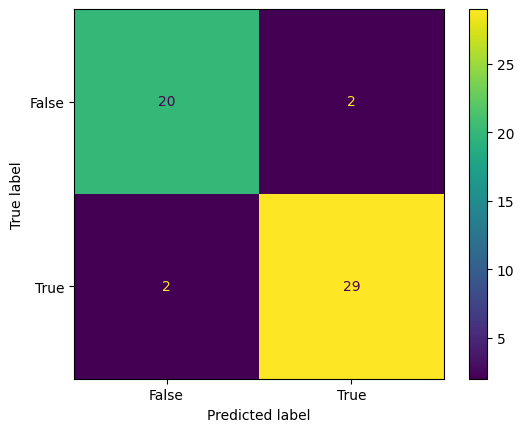

In [25]:
# Performance measures male
prediction_measures(y_testm,X_testm)

### Female set

              precision    recall  f1-score   support

  depression       0.93      0.97      0.95        66
      normal       0.95      0.88      0.91        41

    accuracy                           0.93       107
   macro avg       0.94      0.92      0.93       107
weighted avg       0.94      0.93      0.93       107



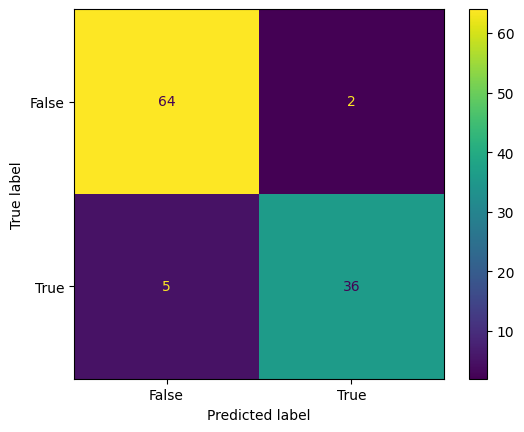

In [26]:
# Performance measures female
prediction_measures(y_testf,X_testf)

### Statistical parity

In [27]:
# predictions
pred_male = model.predict(X_testm)
pred_female = model.predict(X_testf)

def percentage_depression(pred):
    return np.sum(pred == 'depression') / len(pred)

def statistical_parity(predsensitive,predother):
    return percentage_depression(predsensitive)/percentage_depression(predother),percentage_depression(predsensitive),percentage_depression(predother)

statistical_parity(pred_female,pred_male)

(1.5535259133389974, 0.6448598130841121, 0.41509433962264153)

### Equal opportunity

In [28]:
# predictions
pred_male = model.predict(X_testm)
pred_female = model.predict(X_testf)

def true_positives(pred, true):
    return np.sum((pred == 'depression') & (true == "depression"))

def true_negatives(pred, true):
    return np.sum((pred == 'normal') & (true == "normal"))

def true_positive_rate(pred, true):
    return true_positives(pred,true)/(true_positives(pred,true)+true_negatives(pred,true))

def equal_opportunity(predsensitive, truesensitve, predother, trueother):
    return true_positive_rate(predsensitive,truesensitve)/true_positive_rate(predother,trueother)




equal_opportunity(pred_female,y_testf,pred_male,y_testm)



1.568

## Equalised odds

In [29]:
# predictions
pred_male = model.predict(X_testm)
pred_female = model.predict(X_testf)

def true_negative_rate(pred, true):
    return true_negatives(pred,true)/(true_positives(pred,true)+true_negatives(pred,true))

def equalised_odds(predsensitive, truesensitve, predother, trueother):
    return (true_positive_rate(predsensitive,truesensitve)+true_negative_rate(predsensitive,truesensitve))/(true_positive_rate(predother,trueother)+true_negative_rate(predsensitive,truesensitve))

equalised_odds(pred_female,y_testf,pred_male,y_testm)

1.3018065887353878

## Equal accuracy

In [30]:
# predictions
pred_male = model.predict(X_testm)
pred_female = model.predict(X_testf)

def equal_accuracy(predsensitive, truesensitve, predother, trueother):
    return accuracy_score(predsensitive,truesensitve)/accuracy_score(predother,trueother)

equal_accuracy(pred_female,y_testf,pred_male,y_testm)

1.010871638374976